# 1. Set up

In [33]:
!pip install neo4j
!pip install torch
!pip install torch_geometric

# 2. Import necessary libraries

In [2]:
import torch
from torch_geometric.data import HeteroData
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import warnings
import logging
from datetime import datetime, timedelta, date
import random
from neo4j import GraphDatabase

import os
from neo4j.time import Date

In [3]:
warnings.filterwarnings('ignore')

In [4]:
from config import *

# 3. Define global variables

In [5]:
NEO4J_URI = "neo4j://localhost:7687"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "password"

In [6]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 4. Functions

In [7]:
def convert_neo4j_date(x):
    if isinstance(x, Date):
        return date(x.year, x.month, x.day)
    elif isinstance(x, datetime):
        return x.date()
    elif isinstance(x, date):
        return x
    else:
        return pd.NaT

In [8]:
def plot_heterogeneous_results(history, test_results, attention_analysis):
    """
    Visualiza los resultados del modelo heterogéneo
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Historial de entrenamiento
    axes[0, 0].plot(history['train_losses'], label='Train Loss', alpha=0.7)
    axes[0, 0].plot(history['val_losses'], label='Val Loss', alpha=0.7)
    axes[0, 0].set_title('Pérdida durante el entrenamiento')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracies
    axes[0, 1].plot(history['train_accuracies'], label='Train Accuracy', alpha=0.7)
    axes[0, 1].plot(history['val_accuracies'], label='Val Accuracy', alpha=0.7)
    axes[0, 1].set_title('Precisión durante el entrenamiento')
    axes[0, 1].set_xlabel('Época')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 2. Matriz de confusión
    sns.heatmap(test_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Fraude', 'Irregularidad'],
                yticklabels=['Normal', 'Fraude', 'Irregularidad'], ax=axes[1, 0])
    axes[1, 0].set_title('Matriz de Confusión')
    axes[1, 0].set_xlabel('Predicción')
    axes[1, 0].set_ylabel('Verdadero')
    
    # 3. Pesos de atención
    if attention_analysis:
        info_types = list(attention_analysis.keys())
        weights = list(attention_analysis.values())
        
        bars = axes[1, 1].bar(range(len(info_types)), weights, alpha=0.7, color='skyblue')
        axes[1, 1].set_title('Pesos de atención por tipo de información')
        axes[1, 1].set_xlabel('Tipo de información')
        axes[1, 1].set_ylabel('Peso de atención')
        axes[1, 1].set_xticks(range(len(info_types)))
        axes[1, 1].set_xticklabels(info_types, rotation=45, ha='right')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Agregar valores a las barras
        for bar, weight in zip(bars, weights):
            height = bar.get_height()
            axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{weight:.3f}', ha='center', va='bottom')
    else:
        axes[1, 1].text(0.5, 0.5, 'No hay análisis de atención disponible', 
                       ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Análisis de Atención')
    
    plt.tight_layout()
    plt.show()

# 5. Code

## 5.1. Load data from Neo4j

We will be writing the code in order to load the data from neo4j when the time comes.

In [9]:
class Neo4jDataLoader:
    """
    Loads heterogeneous data from Neo4j.
    """
    
    def __init__(self, uri: str, username: str, password: str):
        self.driver = GraphDatabase.driver(uri, auth=(username, password))
        self.logger = logging.getLogger(__name__)
        
    def close(self):
        """
        Used to close the connection
        """
        self.driver.close()
    
    def load_heterogeneous_data(self) -> Dict:
        """
        Loads all the heterogeneous data from Neo4j. The idea is to use all the defined functions for each node.
        """
        print("🔌 Connecting to Neo4j and loading data ...")
        
        with self.driver.session() as session:
            # Load each type of node
            node_data = {
                'contador': self._load_contador_nodes(session),
                'suministro': self._load_suministro_nodes(session),
                'comercializadora': self._load_comercializadora_nodes(session),
                'ubicacion': self._load_ubicacion_nodes(session),
                'concentrador': self._load_concentrador_nodes(session),
                'expediente_fraude': self._load_expediente_fraude_nodes(session)
            }
            
            # Load relations
            edge_data = self._load_heterogeneous_edges(session, node_data)
            
            # Assign fraud labels based on expedientes.
            node_data['contador'] = self._assign_fraud_labels_from_expedientes(
                node_data['contador'], node_data['expediente_fraude'], session
            )
        
        # Let's show now some statistics of the graph
        total_nodes = sum(len(nodes) for nodes in node_data.values())
        total_edges = sum(len(edges) for edges in edge_data.values())
        print(f"✅ Cargados {total_nodes} nodos y {total_edges} relaciones desde Neo4j")
        
        for node_type, df in node_data.items():
            print(f"   - {node_type}: {len(df)} nodos")
        
        return {
            'nodes': node_data,
            'edges': edge_data
        }
    
    def _load_contador_nodes(self, session) -> pd.DataFrame:
        """Loads CONTADOR nodes from Neo4j"""
        
        query = """
        MATCH (c:CONTADOR)
        OPTIONAL MATCH (c)-[:GENERA_MEDICION]->(m:MEDICION)
        WITH c, 
             COUNT(m) as num_mediciones,
             AVG(m.energia_activa) as consumo_promedio,
             MAX(m.energia_activa) as consumo_maximo,
             MIN(m.energia_activa) as consumo_minimo,
             STDEV(m.energia_activa) as variabilidad_consumo
        RETURN c.nis_rad as nis_rad,
               c.numero_contador as numero_contador,
               c.marca_contador as marca,
               c.modelo_contador as modelo,
               c.tipo_aparato as tipo_aparato,
               c.telegest_activo as telegest_activo,
               c.estado_tg as estado_comunicacion,
               c.tension as tension_nominal,
               c.fases_contador as fases,
               c.potencia_maxima as potencia_maxima,
               c.fecha_instalacion as fecha_instalacion,
               c.version_firmware as version_firmware,
               c.estado_contrato as estado_contrato,
               COALESCE(num_mediciones, 0) as num_mediciones,
               COALESCE(consumo_promedio, 0) as consumo_promedio_diario,
               COALESCE(consumo_maximo, 0) as consumo_maximo_registrado,
               COALESCE(consumo_minimo, 0) as consumo_minimo_registrado,
               COALESCE(variabilidad_consumo, 0) as variabilidad_consumo
        ORDER BY c.nis_rad
        """
        # Run the query just defined:
        result = session.run(query)
        records = [dict(record) for record in result]
        
        if not records:
            print("⚠️ We couldn't find CONTADORES.")
        
        df = pd.DataFrame(records)
        
        # Add calculated features
        df["fecha_instalacion"] = df["fecha_instalacion"].map(convert_neo4j_date)
        df["fecha_instalacion"] = pd.to_datetime(df["fecha_instalacion"])

        # Calcula los días como enteros
        df["dias_desde_instalacion"] = (
            pd.Timestamp.now().normalize() - df["fecha_instalacion"]
        ).dt.days.fillna(0)
        
        # Let's create a unique ID for the mapping.
        df['node_id'] = df['nis_rad']
        df.reset_index(drop=True, inplace=True)
        
        return df
    
    def _load_suministro_nodes(self, session) -> pd.DataFrame:
        """Loads SUMINISTRO nodes from Neo4j"""
        
        query = """
        MATCH (s:SUMINISTRO)
        RETURN s.nis_rad as nis_rad,
               s.fecha_alta_suministro as fecha_alta,
               s.estado_contrato as estado_contrato,
               s.tipo_punto as tipo_suministro,
               s.potencia_contratada as potencia_contratada,
               s.potencia_maxima as potencia_maxima_demandada,
               s.tarifa_activa as tarifa_activa,
               s.tension_suministro as tension_suministro,
               s.fases_suministro as fases_suministro,
               s.cnae as cnae,
               s.comercializadora_codigo as comercializadora_codigo
        ORDER BY s.nis_rad
        """
        
        result = session.run(query)
        records = [dict(record) for record in result]
        
        df = pd.DataFrame(records)
        df['node_id'] = df['nis_rad']
        
        df.reset_index(drop=True, inplace=True)
        return df
    
    def _load_comercializadora_nodes(self, session) -> pd.DataFrame:
        """
        Loads COMERCIALIZADORA nodes from Neo4j
        """
        
        query = """
        MATCH (c:COMERCIALIZADORA)
        RETURN c.codigo_comercializadora as codigo_comercializadora,
               c.nombre_comercializadora as nombre_comercializadora
        ORDER BY c.codigo_comercializadora
        """
        
        result = session.run(query)
        records = [dict(record) for record in result]
        
        df = pd.DataFrame(records)
        df['node_id'] = df['codigo_comercializadora']
        
        df.reset_index(drop=True, inplace=True)
        return df
    
    def _load_ubicacion_nodes(self, session) -> pd.DataFrame:
        """
        Loads UBICACION nodes from Neo4j
        """
        
        query = """
        MATCH (u:UBICACION)
        RETURN u.coordenada_x as coordenada_x,
               u.coordenada_y as coordenada_y,
               u.codigo_postal as codigo_postal,
               u.area_ejecucion as area_ejecucion,
               toString(u.coordenada_x) + '_' + toString(u.coordenada_y) as node_id
        ORDER BY u.coordenada_x, u.coordenada_y
        """
        
        result = session.run(query)
        records = [dict(record) for record in result]
        
        df = pd.DataFrame(records)
        
        df.reset_index(drop=True, inplace=True)
        return df
    
    def _load_concentrador_nodes(self, session) -> pd.DataFrame:
        """
        Loads CONCENTRADOR nodes from Neo4j
        """
        
        query = """
        MATCH (c:CONCENTRADOR)
        RETURN c.concentrador_id as concentrador_id,
               c.version_concentrador as version_concentrador,
               c.estado_comunicacion as estado_comunicacion,
               c.tipo_reporte as tipo_reporte
        ORDER BY c.concentrador_id
        """
        
        result = session.run(query)
        records = [dict(record) for record in result]
        
        df = pd.DataFrame(records)
        df['node_id'] = df['concentrador_id']
        
        df.reset_index(drop=True, inplace=True)
        return df
    
    def _load_expediente_fraude_nodes(self, session) -> pd.DataFrame:
        """
        Loads EXPEDIENTE_FRAUDE nodes from Neo4j
        """
        
        query = """
        MATCH (e:EXPEDIENTE_FRAUDE)
        RETURN e.nis_expediente as nis_expediente,
               e.clasificacion_fraude as clasificacion_fraude,
               e.tipo_anomalia as tipo_anomalia,
               e.estado_expediente as estado_expediente,
               e.fecha_acta as fecha_acta,
               e.fecha_inicio_anomalia as fecha_inicio_anomalia,
               e.fecha_fin_anomalia as fecha_fin_anomalia,
               e.energia_liquidable as energia_liquidable,
               e.valoracion_total as valoracion_total,
               e.dias_liquidables as dias_liquidables,
               e.porcentaje_liquidable as porcentaje_liquidable
        ORDER BY e.nis_expediente
        """
        
        result = session.run(query)
        records = [dict(record) for record in result]
        
        df = pd.DataFrame(records)
        if not df.empty:
            df['node_id'] = df['nis_expediente']
            df.reset_index(drop=True, inplace=True)
        
        return df
    
    def _load_heterogeneous_edges(self, session, node_data: Dict) -> Dict:
        """
        Loads all the heterogeneous relations from Neo4j
        """
        
        print("🔗 Loading relations from Neo4j...")
        
        edge_data = {}
        
        # 1. CONTADOR -> SUMINISTRO (relation MIDE_CONSUMO_DE)
        edge_data[('contador', 'mide', 'suministro')] = self._load_edges_from_query(
            session,
            """
            MATCH (c:CONTADOR)-[:MIDE_CONSUMO_DE]->(s:SUMINISTRO)
            RETURN c.nis_rad as source, s.nis_rad as target
            """,
            node_data['contador'], node_data['suministro']
        )
        
        # 2. CONTADOR -> CONCENTRADOR (relation CONECTADO_A)
        edge_data[('contador', 'comunica_via', 'concentrador')] = self._load_edges_from_query(
            session,
            """
            MATCH (c:CONTADOR)-[:CONECTADO_A]->(con:CONCENTRADOR)
            RETURN c.nis_rad as source, con.concentrador_id as target
            """,
            node_data['contador'], node_data['concentrador']
        )
        
        # 3. CONTADOR -> UBICACION (relation INSTALADO_EN)
        edge_data[('contador', 'ubicado_en', 'ubicacion')] = self._load_edges_from_query(
            session,
            """
            MATCH (c:CONTADOR)-[:INSTALADO_EN]->(u:UBICACION)
            RETURN c.nis_rad as source, 
                   toString(u.coordenada_x) + '_' + toString(u.coordenada_y) as target
            """,
            node_data['contador'], node_data['ubicacion']
        )
        
        # 4. CONTADOR -> EXPEDIENTE_FRAUDE (relation INVOLUCRADO_EN_FRAUDE)
        if not node_data['expediente_fraude'].empty:
            edge_data[('contador', 'involucrado_en', 'expediente_fraude')] = self._load_edges_from_query(
                session,
                """
                MATCH (c:CONTADOR)-[:INVOLUCRADO_EN_FRAUDE]->(e:EXPEDIENTE_FRAUDE)
                RETURN c.nis_rad as source, e.nis_expediente as target
                """,
                node_data['contador'], node_data['expediente_fraude']
            )
        
        # 5. SUMINISTRO -> COMERCIALIZADORA (basado en código comercializadora)
        edge_data[('suministro', 'contratado_con', 'comercializadora')] = self._create_suministro_comercializadora_edges(
            node_data['suministro'], node_data['comercializadora']
        )
        
        # 6. Proximity relations between CONTADORES (These ones are simulated)
        edge_data[('contador', 'cerca_de', 'contador')] = self._create_contador_proximidad_edges(
            node_data['contador'], node_data['ubicacion']
        )
        
        # 7. Similar CONTADORES in terms of MARCA/MODELO
        edge_data[('contador', 'similar_a', 'contador')] = self._create_contador_similar_edges(
            node_data['contador']
        )
        
        return edge_data
    
    def _load_edges_from_query(self, session, query: str, source_df: pd.DataFrame, 
                             target_df: pd.DataFrame) -> List[List[int]]:
        """
        Carga relaciones desde Neo4j usando una query específica
        """
        
        result = session.run(query)
        edges = []
        
        # Crear mapeos de node_id a índice
        source_map = {node_id: idx for idx, node_id in enumerate(source_df['node_id'])}
        target_map = {node_id: idx for idx, node_id in enumerate(target_df['node_id'])}
        
        for record in result:
            source_id = record['source']
            target_id = record['target']
            
            if source_id in source_map and target_id in target_map:
                source_idx = source_map[source_id]
                target_idx = target_map[target_id]
                edges.append([source_idx, target_idx])
        
        # If there are no relations in the db, we create some basic ones for testing
        if not edges and len(source_df) > 0 and len(target_df) > 0:
            print(f"   ⚠️ We couldn't find real relations, creating test relations...")
            for i in range(min(len(source_df), len(target_df))):
                target_idx = i % len(target_df)
                edges.append([i, target_idx])
        
        return edges
    
    def _create_suministro_comercializadora_edges(self, suministros: pd.DataFrame, 
                                                comercializadoras: pd.DataFrame) -> List[List[int]]:
        """
        Creates relations SUMINISTRO -> COMERCIALIZADORA based on the code
        """
        
        edges = []
        com_map = {row['codigo_comercializadora']: idx 
                  for idx, row in comercializadoras.iterrows()}
        
        for idx, row in suministros.iterrows():
            com_codigo = row.get('comercializadora_codigo', 'COM_001')
            if com_codigo in com_map:
                edges.append([idx, com_map[com_codigo]])
            else:
                # Assign randomly if the COMERCIALIZADORA does not exist
                com_idx = np.random.randint(0, len(comercializadoras))
                edges.append([idx, com_idx])
        
        return edges
    
    def _create_contador_proximidad_edges(self, contadores: pd.DataFrame, 
                                        ubicaciones: pd.DataFrame) -> List[List[int]]:
        """
        Crea relaciones de proximidad entre contadores
        """
        
        edges = []
        # Simulamos proximidad: cada contador se conecta con 2-4 vecinos
        for i in range(len(contadores)):
            num_neighbors = np.random.randint(2, 5)
            for _ in range(num_neighbors):
                neighbor_idx = np.random.randint(0, len(contadores))
                if neighbor_idx != i:
                    edges.append([i, neighbor_idx])
        
        return edges
    
    def _create_contador_similar_edges(self, contadores: pd.DataFrame) -> List[List[int]]:
        """Crea relaciones entre contadores similares (misma marca/modelo)"""
        
        edges = []
        
        # Agrupar por marca y modelo
        for marca in contadores['marca'].unique():
            for modelo in contadores['modelo'].unique():
                subset_indices = contadores[
                    (contadores['marca'] == marca) & (contadores['modelo'] == modelo)
                ].index.tolist()
                
                # Conectar contadores del mismo tipo
                for i in range(len(subset_indices)):
                    for j in range(i + 1, min(i + 4, len(subset_indices))):
                        edges.append([subset_indices[i], subset_indices[j]])
                        edges.append([subset_indices[j], subset_indices[i]])
        
        return edges
    
    def _assign_fraud_labels_from_expedientes(self, contadores: pd.DataFrame, 
                                           expedientes: pd.DataFrame, session) -> pd.DataFrame:
        """Asigna etiquetas de fraude basadas en expedientes reales"""
        
        contadores = contadores.copy()
        
        # Inicializar todas las etiquetas como NORMAL
        contadores['label'] = 'NORMAL'
        
        if not expedientes.empty:
            # Obtener relaciones contador -> expediente
            query = """
            MATCH (c:CONTADOR)-[:INVOLUCRADO_EN_FRAUDE]->(e:EXPEDIENTE_FRAUDE)
            RETURN c.nis_rad as contador_nis, e.clasificacion_fraude as clasificacion
            """
            
            result = session.run(query)
            fraud_relations = [dict(record) for record in result]
            
            # Crear mapeo de NIS a índice
            nis_to_idx = {row['nis_rad']: idx for idx, row in contadores.iterrows()}
            
            # Asignar etiquetas basadas en clasificación de fraude
            fraud_count = 0
            irregularity_count = 0
            
            for relation in fraud_relations:
                contador_nis = relation['contador_nis']
                clasificacion = relation['clasificacion']
                
                if contador_nis in nis_to_idx:
                    idx = nis_to_idx[contador_nis]
                    
                    if clasificacion and 'FRAUDE' in clasificacion.upper():
                        contadores.loc[idx, 'label'] = 'FRAUDE'
                        fraud_count += 1
                    elif clasificacion and any(term in clasificacion.upper() 
                                             for term in ['IRREGULARIDAD', 'ANOMALIA']):
                        contadores.loc[idx, 'label'] = 'IRREGULARIDAD'
                        irregularity_count += 1
            
            normal_count = len(contadores) - fraud_count - irregularity_count
            print(f"✅ Etiquetas desde BD: {normal_count} Normal, {fraud_count} Fraude, {irregularity_count} Irregularidad")
        
        else:
            # Si no hay expedientes, simular algunas etiquetas para prueba
            print("⚠️ No se encontraron expedientes de fraude, simulando etiquetas...")
            num_fraudes = max(1, int(len(contadores) * 0.05))  # 5% fraudes
            num_irregularidades = max(1, int(len(contadores) * 0.03))  # 3% irregularidades
            
            fraud_indices = np.random.choice(len(contadores), num_fraudes, replace=False)
            remaining_indices = [i for i in range(len(contadores)) if i not in fraud_indices]
            irregularity_indices = np.random.choice(remaining_indices, num_irregularidades, replace=False)
            
            for idx in fraud_indices:
                contadores.loc[idx, 'label'] = 'FRAUDE'
            
            for idx in irregularity_indices:
                contadores.loc[idx, 'label'] = 'IRREGULARIDAD'
            
            normal_count = len(contadores) - num_fraudes - num_irregularidades
            print(f"✅ Etiquetas simuladas: {normal_count} Normal, {num_fraudes} Fraude, {num_irregularidades} Irregularidad")
        
        return contadores

## 5.2. Simualte the data

We will use a simulator of data as done in the GNN_dummy:

In [10]:
class HeterogeneousDataSimulator:
    """
    Simulate the data for an heterogeneous complete graph.
    """
    
    def __init__(self):
        np.random.seed(RANDOM_SEED)
        random.seed(RANDOM_SEED)
        
    def generate_heterogeneous_data(self) -> Dict:
        """
        Generates a complete heterogeneous dataset.
        """
        
        print("🎲 Generando datos heterogéneos complejos...")
        
        # We generate nodes for each type:
        node_data = {
            'contador': self._generate_contador_nodes(),
            'suministro': self._generate_suministro_nodes(),
            'comercializadora': self._generate_comercializadora_nodes(),
            'ubicacion': self._generate_ubicacion_nodes(),
            'concentrador': self._generate_concentrador_nodes(),
            'cliente': self._generate_cliente_nodes(),
            'transformador': self._generate_transformador_nodes(),
            'zona': self._generate_zona_nodes()
        }
        
        # We generate heterogeneous relations also making use of the _generate_heterogeneous_edges function:
        edge_data = self._generate_heterogeneous_edges(node_data)
        
        # We add labels of fraud to each contador.
        node_data['contador'] = self._assign_fraud_labels(node_data['contador'])

        # Show how many nodes and relations we have:
        print(f"✅ Generados {sum(len(nodes) for nodes in node_data.values())} nodos")
        print(f"✅ Generadas {sum(len(edges) for edges in edge_data.values())} relaciones")
        
        return {
            'nodes': node_data,
            'edges': edge_data
        }
    
    def _generate_contador_nodes(self) -> pd.DataFrame:
        """
        Generates contador nodes with detailed features.
        """
        
        data = {
            'node_id': [f"CNT_{i:06d}" for i in range(NUM_CONTADORES_ADV)],
            
            # Características técnicas
            'marca': np.random.choice(['LANDIS', 'ITRON', 'CIRCUTOR', 'SCHNEIDER', 'ABB'], NUM_CONTADORES_ADV),
            'modelo': np.random.choice(['E350', 'E450', 'A1140', 'A1800', 'B23'], NUM_CONTADORES_ADV),
            'tipo_aparato': np.random.choice(['ELECTRONICO', 'ELECTROMECANICO', 'HIBRIDO'], 
                                           NUM_CONTADORES_ADV, p=[0.7, 0.2, 0.1]),
            'numero_serie': [f"SN{random.randint(100000, 999999)}" for _ in range(NUM_CONTADORES_ADV)],
            'fecha_fabricacion': pd.to_datetime([
                datetime.now() - timedelta(days=random.randint(30, 3650)) 
                for _ in range(NUM_CONTADORES_ADV)
            ]),
            'fecha_instalacion': pd.to_datetime([
                datetime.now() - timedelta(days=random.randint(1, 1825)) 
                for _ in range(NUM_CONTADORES_ADV)
            ]),
            
            # Características eléctricas
            'potencia_maxima': np.random.lognormal(8.5, 0.8, NUM_CONTADORES_ADV),
            'tension_nominal': np.random.choice([230, 400], NUM_CONTADORES_ADV, p=[0.6, 0.4]),
            'fases': np.random.choice([1, 3], NUM_CONTADORES_ADV, p=[0.7, 0.3]),
            'clase_precision': np.random.choice([1, 2, 0.5], NUM_CONTADORES_ADV, p=[0.6, 0.3, 0.1]),
            'intensidad_maxima': np.random.lognormal(3.0, 0.5, NUM_CONTADORES_ADV),
            
            # Telegestión y comunicaciones
            'telegest_activo': np.random.choice([True, False], NUM_CONTADORES_ADV, p=[0.85, 0.15]),
            'protocolo_comunicacion': np.random.choice(['PLC', 'RF', 'GPRS', 'ETHERNET'], 
                                                     NUM_CONTADORES_ADV, p=[0.4, 0.3, 0.2, 0.1]),
            'version_firmware': [f"v{random.randint(1,5)}.{random.randint(0,9)}.{random.randint(0,9)}" 
                               for _ in range(NUM_CONTADORES_ADV)],
            'estado_comunicacion': np.random.choice(['ACTIVO', 'INTERMITENTE', 'PERDIDO'], 
                                                  NUM_CONTADORES_ADV, p=[0.8, 0.15, 0.05]),
            
            # Métricas operacionales
            'dias_desde_instalacion': [(datetime.now() - pd.to_datetime([
                datetime.now() - timedelta(days=random.randint(1, 1825)) 
                for _ in range(NUM_CONTADORES_ADV)
            ])[i]).days for i in range(NUM_CONTADORES_ADV)],
            'num_reinicios': np.random.poisson(2, NUM_CONTADORES_ADV),
            'eventos_alarma': np.random.poisson(1, NUM_CONTADORES_ADV),
            'calidad_senal': np.random.beta(8, 2, NUM_CONTADORES_ADV) * 100,
            
            # Consumo y patrones
            'consumo_promedio_diario': np.random.lognormal(3.5, 1.2, NUM_CONTADORES_ADV),
            'consumo_maximo_registrado': np.random.lognormal(4.0, 1.0, NUM_CONTADORES_ADV),
            'consumo_minimo_registrado': np.random.exponential(5, NUM_CONTADORES_ADV),
            'variabilidad_consumo': np.random.exponential(20, NUM_CONTADORES_ADV),
            'patron_horario': np.random.choice(['RESIDENCIAL', 'COMERCIAL', 'INDUSTRIAL'], 
                                             NUM_CONTADORES_ADV, p=[0.6, 0.3, 0.1]),
            'dias_sin_consumo': np.random.poisson(3, NUM_CONTADORES_ADV),
            'picos_consumo_anormales': np.random.poisson(0.5, NUM_CONTADORES_ADV),
            
            # Mantenimiento y incidencias
            'ultima_inspeccion': pd.to_datetime([
                datetime.now() - timedelta(days=random.randint(0, 730)) 
                for _ in range(NUM_CONTADORES_ADV)
            ]),
            'resultado_ultima_inspeccion': np.random.choice(['CORRECTO', 'ANOMALIA_MENOR', 'ANOMALIA_MAYOR'], 
                                                          NUM_CONTADORES_ADV, p=[0.85, 0.12, 0.03]),
            'num_averias': np.random.poisson(0.3, NUM_CONTADORES_ADV),
            'dias_fuera_servicio': np.random.poisson(1, NUM_CONTADORES_ADV),
            
            # Indicadores de riesgo
            'score_fiabilidad': np.random.beta(7, 3, NUM_CONTADORES_ADV) * 100,
            'anomalias_detectadas': np.random.poisson(0.8, NUM_CONTADORES_ADV),
            'tendencia_consumo': np.random.choice(['ESTABLE', 'CRECIENTE', 'DECRECIENTE'], 
                                                NUM_CONTADORES_ADV, p=[0.7, 0.2, 0.1])
        }
        
        return pd.DataFrame(data)
    
    def _generate_suministro_nodes(self) -> pd.DataFrame:
        """
        Generates nodes of suministros/contratos
        """
        
        data = {
            'node_id': [f"SUM_{i:06d}" for i in range(NUM_SUMINISTROS_ADV)],
            
            # Datos contractuales
            'fecha_alta': pd.to_datetime([
                datetime.now() - timedelta(days=random.randint(1, 2555)) 
                for _ in range(NUM_SUMINISTROS_ADV)
            ]),
            'fecha_baja': pd.to_datetime([
                datetime.now() + timedelta(days=random.randint(-30, 365)) if random.random() < 0.05 else None
                for _ in range(NUM_SUMINISTROS_ADV)
            ]),
            'estado_contrato': np.random.choice(['ACTIVO', 'SUSPENDIDO', 'BAJA'], 
                                              NUM_SUMINISTROS_ADV, p=[0.92, 0.05, 0.03]),
            'tipo_suministro': np.random.choice(['RESIDENCIAL', 'COMERCIAL', 'INDUSTRIAL', 'AGRICOLA'], 
                                              NUM_SUMINISTROS_ADV, p=[0.6, 0.25, 0.1, 0.05]),
            
            # Potencia y tarifa
            'potencia_contratada': np.random.lognormal(8.0, 1.0, NUM_SUMINISTROS_ADV),
            'potencia_maxima_demandada': np.random.lognormal(8.2, 0.8, NUM_SUMINISTROS_ADV),
            'tarifa_activa': np.random.choice(['2.0TD', '3.0TD', '6.1TD', '6.2TD'], 
                                            NUM_SUMINISTROS_ADV, p=[0.7, 0.2, 0.05, 0.05]),
            'discriminacion_horaria': np.random.choice([True, False], NUM_SUMINISTROS_ADV, p=[0.4, 0.6]),
            
            # CNAE y actividad
            'cnae': np.random.choice(['4711', '5210', '9820', '1071', '4540'], 
                                   NUM_SUMINISTROS_ADV, p=[0.3, 0.25, 0.2, 0.15, 0.1]),
            'actividad_declarada': np.random.choice(['VIVIENDA', 'COMERCIO', 'OFICINA', 'INDUSTRIA', 'OTROS'], 
                                                  NUM_SUMINISTROS_ADV, p=[0.6, 0.2, 0.1, 0.05, 0.05]),
            
            # Facturación y pagos
            'facturacion_mensual_promedio': np.random.lognormal(4.5, 1.0, NUM_SUMINISTROS_ADV),
            'dias_morosidad': np.random.exponential(5, NUM_SUMINISTROS_ADV),
            'num_impagos': np.random.poisson(0.2, NUM_SUMINISTROS_ADV),
            'metodo_pago': np.random.choice(['DOMICILIACION', 'TRANSFERENCIA', 'EFECTIVO'], 
                                          NUM_SUMINISTROS_ADV, p=[0.8, 0.15, 0.05]),
            
            # Consumo contractual
            'consumo_anual_estimado': np.random.lognormal(7.0, 1.2, NUM_SUMINISTROS_ADV),
            'consumo_anual_real': np.random.lognormal(7.1, 1.1, NUM_SUMINISTROS_ADV),
            'desviacion_consumo_estimado': np.random.normal(0, 25, NUM_SUMINISTROS_ADV),
            
            # Modificaciones contractuales
            'num_cambios_potencia': np.random.poisson(0.3, NUM_SUMINISTROS_ADV),
            'num_cambios_tarifa': np.random.poisson(0.2, NUM_SUMINISTROS_ADV),
            'ultima_modificacion': pd.to_datetime([
                datetime.now() - timedelta(days=random.randint(30, 730)) if random.random() < 0.3 else None
                for _ in range(NUM_SUMINISTROS_ADV)
            ])
        }
        
        return pd.DataFrame(data)
    
    def _generate_comercializadora_nodes(self) -> pd.DataFrame:
        """Genera nodos de comercializadoras"""
        
        nombres = ['ENDESA', 'IBERDROLA', 'NATURGY', 'VIESGO', 'EDP', 'HOLALUZ', 'FACTOR', 'LUCERA', 
                  'PEPEENERGY', 'SOMA', 'BASER', 'ALDRO', 'REPSOL', 'TOTALENERGIES', 'GALP', 
                  'GESTERNOVA', 'NEXUS', 'ACCIONA', 'CIDE', 'COMPETENCIA']
        
        data = {
            'node_id': [f"COM_{i:03d}" for i in range(NUM_COMERCIALIZADORAS_ADV)],
            'nombre': nombres[:NUM_COMERCIALIZADORAS_ADV],
            'tipo_empresa': np.random.choice(['GRAN_EMPRESA', 'MEDIANA_EMPRESA', 'STARTUP'], 
                                           NUM_COMERCIALIZADORAS_ADV, p=[0.6, 0.3, 0.1]),
            'NUM_CLIENTES_ADV_total': np.random.lognormal(10, 2, NUM_COMERCIALIZADORAS_ADV),
            'cuota_mercado': np.random.exponential(5, NUM_COMERCIALIZADORAS_ADV),
            'anos_operando': np.random.randint(1, 25, NUM_COMERCIALIZADORAS_ADV),
            'rating_financiero': np.random.choice(['AAA', 'AA', 'A', 'BBB', 'BB'], 
                                                NUM_COMERCIALIZADORAS_ADV, p=[0.1, 0.2, 0.4, 0.2, 0.1]),
            'num_reclamaciones': np.random.poisson(50, NUM_COMERCIALIZADORAS_ADV),
            'tiempo_respuesta_promedio': np.random.exponential(3, NUM_COMERCIALIZADORAS_ADV),
            'score_satisfaccion': np.random.beta(6, 2, NUM_COMERCIALIZADORAS_ADV) * 10,
            'precios_competitivos': np.random.beta(5, 3, NUM_COMERCIALIZADORAS_ADV),
            'productos_verdes': np.random.choice([True, False], NUM_COMERCIALIZADORAS_ADV, p=[0.7, 0.3]),
            'servicios_digitales': np.random.choice([True, False], NUM_COMERCIALIZADORAS_ADV, p=[0.8, 0.2])
        }
        
        return pd.DataFrame(data)
    
    def _generate_ubicacion_nodes(self) -> pd.DataFrame:
        """Genera nodos de ubicaciones geográficas"""
        
        # Simular coordenadas en España
        lat_base, lon_base = 40.4168, -3.7038  # Madrid centro
        
        data = {
            'node_id': [f"UBI_{i:06d}" for i in range(NUM_UBICACIONES_ADV)],
            'latitud': np.random.normal(lat_base, 2.5, NUM_UBICACIONES_ADV),
            'longitud': np.random.normal(lon_base, 3.0, NUM_UBICACIONES_ADV),
            'coordenada_utm_x': np.random.uniform(300000, 800000, NUM_UBICACIONES_ADV),
            'coordenada_utm_y': np.random.uniform(4200000, 4800000, NUM_UBICACIONES_ADV),
            'codigo_postal': [f"{random.randint(1, 52):02d}{random.randint(1, 999):03d}" 
                            for _ in range(NUM_UBICACIONES_ADV)],
            'provincia': np.random.choice(['MADRID', 'BARCELONA', 'VALENCIA', 'SEVILLA', 'BILBAO', 'ZARAGOZA'], 
                                       NUM_UBICACIONES_ADV, p=[0.3, 0.25, 0.15, 0.1, 0.1, 0.1]),
            'tipo_zona': np.random.choice(['URBANA', 'RURAL', 'SEMIURBANA'], 
                                        NUM_UBICACIONES_ADV, p=[0.6, 0.2, 0.2]),
            'densidad_poblacion': np.random.lognormal(6, 1.5, NUM_UBICACIONES_ADV),
            'nivel_socioeconomico': np.random.choice(['ALTO', 'MEDIO_ALTO', 'MEDIO', 'MEDIO_BAJO', 'BAJO'], 
                                                   NUM_UBICACIONES_ADV, p=[0.1, 0.2, 0.4, 0.2, 0.1]),
            'indice_criminalidad': np.random.exponential(3, NUM_UBICACIONES_ADV),
            'accesibilidad_tecnica': np.random.choice(['FACIL', 'NORMAL', 'DIFICIL'], 
                                                    NUM_UBICACIONES_ADV, p=[0.6, 0.3, 0.1]),
            'cobertura_comunicaciones': np.random.beta(8, 2, NUM_UBICACIONES_ADV) * 100,
            'historial_fraudes': np.random.poisson(0.5, NUM_UBICACIONES_ADV),
            'NUM_CONTADORES_ADV_zona': np.random.poisson(10, NUM_UBICACIONES_ADV),
            'distancia_centro_transformacion': np.random.exponential(500, NUM_UBICACIONES_ADV),
            'calidad_suministro': np.random.beta(9, 1, NUM_UBICACIONES_ADV) * 100
        }
        
        return pd.DataFrame(data)
    
    def _generate_concentrador_nodes(self) -> pd.DataFrame:
        """Genera nodos de concentradores de comunicaciones"""
        
        data = {
            'node_id': [f"CON_{i:04d}" for i in range(NUM_CONCENTRADORES_ADV)],
            'fabricante': np.random.choice(['ZIV', 'SAGITTARIUS', 'PRIME', 'LANDIS', 'ITRON'], 
                                         NUM_CONCENTRADORES_ADV),
            'modelo_concentrador': np.random.choice(['DCU_500', 'DCU_1000', 'PRIME_Master', 'G3_Head'], 
                                                  NUM_CONCENTRADORES_ADV),
            'version_software': [f"v{random.randint(2,6)}.{random.randint(0,9)}" 
                               for _ in range(NUM_CONCENTRADORES_ADV)],
            'capacidad_maxima': np.random.choice([500, 1000, 2000, 5000], NUM_CONCENTRADORES_ADV),
            'contadores_conectados': np.random.randint(10, 500, NUM_CONCENTRADORES_ADV),
            'tasa_lectura_exitosa': np.random.beta(9, 1, NUM_CONCENTRADORES_ADV) * 100,
            'latencia_promedio': np.random.exponential(2, NUM_CONCENTRADORES_ADV),
            'uptime_porcentaje': np.random.beta(95, 5, NUM_CONCENTRADORES_ADV) * 100,
            'num_reinicios_mes': np.random.poisson(1, NUM_CONCENTRADORES_ADV),
            'errores_comunicacion': np.random.poisson(5, NUM_CONCENTRADORES_ADV),
            'temperatura_operacion': np.random.normal(35, 10, NUM_CONCENTRADORES_ADV),
            'nivel_bateria': np.random.beta(8, 2, NUM_CONCENTRADORES_ADV) * 100,
            'calidad_senal_red': np.random.beta(7, 3, NUM_CONCENTRADORES_ADV) * 100,
            'protocolo_principal': np.random.choice(['PLC_PRIME', 'PLC_G3', 'RF_169MHz', 'GPRS'], 
                                                  NUM_CONCENTRADORES_ADV, p=[0.4, 0.3, 0.2, 0.1]),
            'backup_comunicacion': np.random.choice([True, False], NUM_CONCENTRADORES_ADV, p=[0.7, 0.3]),
            'ultima_actualizacion': pd.to_datetime([
                datetime.now() - timedelta(days=random.randint(1, 365)) 
                for _ in range(NUM_CONCENTRADORES_ADV)
            ])
        }
        
        return pd.DataFrame(data)
    
    def _generate_cliente_nodes(self) -> pd.DataFrame:
        """Genera nodos de clientes"""
        
        data = {
            'node_id': [f"CLI_{i:06d}" for i in range(NUM_CLIENTES_ADV)],
            'tipo_cliente': np.random.choice(['PERSONA_FISICA', 'PERSONA_JURIDICA', 'ADMINISTRACION'], 
                                           NUM_CLIENTES_ADV, p=[0.8, 0.15, 0.05]),
            'antiguedad_cliente': np.random.exponential(5, NUM_CLIENTES_ADV),
            'NUM_SUMINISTROS_ADV': np.random.choice([1, 2, 3, 4, 5], NUM_CLIENTES_ADV, p=[0.7, 0.2, 0.05, 0.03, 0.02]),
            'score_crediticio': np.random.beta(6, 4, NUM_CLIENTES_ADV) * 1000,
            'ingresos_declarados': np.random.lognormal(10, 0.8, NUM_CLIENTES_ADV),
            'edad_estimada': np.random.normal(45, 15, NUM_CLIENTES_ADV),
            'canal_preferido': np.random.choice(['ONLINE', 'TELEFONO', 'PRESENCIAL', 'EMAIL'], 
                                              NUM_CLIENTES_ADV, p=[0.4, 0.3, 0.2, 0.1]),
            'num_reclamaciones': np.random.poisson(0.5, NUM_CLIENTES_ADV),
            'num_cambios_comercializadora': np.random.poisson(1, NUM_CLIENTES_ADV),
            'satisfaccion_cliente': np.random.beta(7, 3, NUM_CLIENTES_ADV) * 10,
            'uso_servicios_digitales': np.random.choice([True, False], NUM_CLIENTES_ADV, p=[0.6, 0.4]),
            'conciencia_energetica': np.random.beta(5, 5, NUM_CLIENTES_ADV) * 10,
            'historial_impagos': np.random.poisson(0.3, NUM_CLIENTES_ADV),
            'metodo_contacto_preferido': np.random.choice(['EMAIL', 'SMS', 'CARTA', 'TELEFONO'], 
                                                        NUM_CLIENTES_ADV, p=[0.5, 0.3, 0.1, 0.1]),
            'programa_fidelizacion': np.random.choice([True, False], NUM_CLIENTES_ADV, p=[0.3, 0.7])
        }
        
        return pd.DataFrame(data)
    
    def _generate_transformador_nodes(self) -> pd.DataFrame:
        """Genera nodos de transformadores de distribución"""
        
        data = {
            'node_id': [f"TRF_{i:04d}" for i in range(NUM_TRANSFORMADORES_ADV)],
            'potencia_nominal': np.random.choice([25, 50, 100, 160, 250, 400, 630], 
                                               NUM_TRANSFORMADORES_ADV, p=[0.1, 0.2, 0.25, 0.2, 0.15, 0.08, 0.02]),
            'tension_primaria': np.random.choice([15000, 20000, 25000], NUM_TRANSFORMADORES_ADV, p=[0.4, 0.4, 0.2]),
            'tension_secundaria': np.random.choice([400, 230], NUM_TRANSFORMADORES_ADV, p=[0.7, 0.3]),
            'año_fabricacion': np.random.randint(1980, 2024, NUM_TRANSFORMADORES_ADV),
            'fabricante_transformador': np.random.choice(['SCHNEIDER', 'ABB', 'SIEMENS', 'ORMAZABAL', 'COOPER'], 
                                                       NUM_TRANSFORMADORES_ADV),
            'tipo_refrigeracion': np.random.choice(['ACEITE', 'SECO', 'SILICONA'], 
                                                 NUM_TRANSFORMADORES_ADV, p=[0.6, 0.3, 0.1]),
            'carga_actual_porcentaje': np.random.beta(6, 4, NUM_TRANSFORMADORES_ADV) * 100,
            'carga_maxima_historica': np.random.beta(8, 2, NUM_TRANSFORMADORES_ADV) * 100,
            'temperatura_operacion': np.random.normal(45, 15, NUM_TRANSFORMADORES_ADV),
            'NUM_CONTADORES_ADV_alimentados': np.random.poisson(30, NUM_TRANSFORMADORES_ADV),
            'perdidas_tecnicas': np.random.beta(2, 8, NUM_TRANSFORMADORES_ADV) * 5,
            'ultima_revision': pd.to_datetime([
                datetime.now() - timedelta(days=random.randint(30, 1095)) 
                for _ in range(NUM_TRANSFORMADORES_ADV)
            ]),
            'estado_conservacion': np.random.choice(['EXCELENTE', 'BUENO', 'REGULAR', 'MALO'], 
                                                  NUM_TRANSFORMADORES_ADV, p=[0.2, 0.5, 0.25, 0.05]),
            'num_averias': np.random.poisson(0.5, NUM_TRANSFORMADORES_ADV),
            'tiempo_fuera_servicio': np.random.exponential(2, NUM_TRANSFORMADORES_ADV),
            'monitorizacion_remota': np.random.choice([True, False], NUM_TRANSFORMADORES_ADV, p=[0.4, 0.6]),
            'sistema_proteccion': np.random.choice(['FUSIBLES', 'INTERRUPTOR', 'AUTOMATICO'], 
                                                 NUM_TRANSFORMADORES_ADV, p=[0.3, 0.4, 0.3])
        }
        
        return pd.DataFrame(data)
    
    def _generate_zona_nodes(self) -> pd.DataFrame:
        """Genera nodos de zonas de distribución"""
        
        data = {
            'node_id': [f"ZON_{i:03d}" for i in range(NUM_ZONAS_ADV)],
            'nombre_zona': [f"ZONA_{chr(65 + i//26)}{i%26 + 1}" for i in range(NUM_ZONAS_ADV)],
            'tipo_zona_electrica': np.random.choice(['URBANA_DENSA', 'URBANA', 'RURAL', 'INDUSTRIAL'], 
                                                  NUM_ZONAS_ADV, p=[0.2, 0.4, 0.3, 0.1]),
            'NUM_TRANSFORMADORES_ADV': np.random.poisson(8, NUM_ZONAS_ADV),
            'NUM_CONTADORES_ADV_zona': np.random.poisson(200, NUM_ZONAS_ADV),
            'longitud_red_mt': np.random.exponential(10, NUM_ZONAS_ADV),  # km
            'longitud_red_bt': np.random.exponential(25, NUM_ZONAS_ADV),  # km
            'indice_calidad_suministro': np.random.beta(8, 2, NUM_ZONAS_ADV) * 10,
            'tiempo_medio_interrupcion': np.random.exponential(2, NUM_ZONAS_ADV),  # horas/año
            'perdidas_tecnicas_zona': np.random.beta(3, 7, NUM_ZONAS_ADV) * 10,  # %
            'perdidas_no_tecnicas': np.random.exponential(2, NUM_ZONAS_ADV),  # %
            'densidad_carga': np.random.lognormal(3, 1, NUM_ZONAS_ADV),  # MW/km²
            'crecimiento_demanda': np.random.normal(2, 1, NUM_ZONAS_ADV),  # %/año
            'num_incidencias_mes': np.random.poisson(3, NUM_ZONAS_ADV),
            'cobertura_telemedida': np.random.beta(8, 2, NUM_ZONAS_ADV) * 100,  # %
            'antiguedad_red_promedio': np.random.normal(25, 10, NUM_ZONAS_ADV),  # años
            'inversion_mantenimiento': np.random.lognormal(8, 1, NUM_ZONAS_ADV),  # €/año
            'personal_tecnico_asignado': np.random.poisson(2, NUM_ZONAS_ADV),
            'vehiculos_disponibles': np.random.poisson(1, NUM_ZONAS_ADV),
            'almacen_material': np.random.choice([True, False], NUM_ZONAS_ADV, p=[0.6, 0.4])
        }
        
        return pd.DataFrame(data)
    
    def _generate_heterogeneous_edges(self, node_data: Dict) -> Dict:
        """Genera todas las relaciones heterogéneas entre tipos de nodos"""
        
        print("🔗 Generando relaciones heterogéneas...")
        
        edge_data = {}
        
        # 1. CONTADOR -> SUMINISTRO (1:1)
        edge_data[('contador', 'mide', 'suministro')] = self._create_contador_suministro_edges(
            node_data['contador'], node_data['suministro']
        )
        
        # 2. SUMINISTRO -> COMERCIALIZADORA (N:1)
        edge_data[('suministro', 'contratado_con', 'comercializadora')] = self._create_suministro_comercializadora_edges(
            node_data['suministro'], node_data['comercializadora']
        )
        
        # 3. CONTADOR -> UBICACION (N:1)
        edge_data[('contador', 'ubicado_en', 'ubicacion')] = self._create_contador_ubicacion_edges(
            node_data['contador'], node_data['ubicacion']
        )
        
        # 4. CONTADOR -> CONCENTRADOR (N:1)
        edge_data[('contador', 'comunica_via', 'concentrador')] = self._create_contador_concentrador_edges(
            node_data['contador'], node_data['concentrador']
        )
        
        # 5. SUMINISTRO -> CLIENTE (N:1)
        edge_data[('suministro', 'pertenece_a', 'cliente')] = self._create_suministro_cliente_edges(
            node_data['suministro'], node_data['cliente']
        )
        
        # 6. CONTADOR -> TRANSFORMADOR (N:1)
        edge_data[('contador', 'alimentado_por', 'transformador')] = self._create_contador_transformador_edges(
            node_data['contador'], node_data['transformador']
        )
        
        # 7. TRANSFORMADOR -> ZONA (N:1)
        edge_data[('transformador', 'pertenece_zona', 'zona')] = self._create_transformador_zona_edges(
            node_data['transformador'], node_data['zona']
        )
        
        # 8. UBICACION -> ZONA (N:1)
        edge_data[('ubicacion', 'dentro_de', 'zona')] = self._create_ubicacion_zona_edges(
            node_data['ubicacion'], node_data['zona']
        )
        
        # 9. Relaciones intra-tipo
        
        # CONTADOR -> CONTADOR (proximidad geográfica)
        edge_data[('contador', 'cerca_de', 'contador')] = self._create_contador_contador_edges(
            node_data['contador'], node_data['ubicacion']
        )
        
        # CONTADOR -> CONTADOR (mismo modelo/marca)
        edge_data[('contador', 'similar_a', 'contador')] = self._create_contador_similar_edges(
            node_data['contador']
        )
        
        # TRANSFORMADOR -> TRANSFORMADOR (misma zona)
        edge_data[('transformador', 'conectado_a', 'transformador')] = self._create_transformador_transformador_edges(
            node_data['transformador']
        )
        
        # CLIENTE -> CLIENTE (múltiples suministros)
        edge_data[('cliente', 'relacionado_con', 'cliente')] = self._create_cliente_cliente_edges(
            node_data['cliente']
        )
        
        return edge_data
    
    def _create_contador_suministro_edges(self, contadores: pd.DataFrame, suministros: pd.DataFrame) -> List:
        """Relación 1:1 entre contadores y suministros"""
        edges = []
        for i in range(min(len(contadores), len(suministros))):
            edges.append([i, i])  # Correspondencia 1:1
        return edges
    
    def _create_suministro_comercializadora_edges(self, suministros: pd.DataFrame, comercializadoras: pd.DataFrame) -> List:
        """Relación N:1 suministros -> comercializadoras"""
        edges = []
        for i in range(len(suministros)):
            com_idx = np.random.randint(0, len(comercializadoras))
            edges.append([i, com_idx])
        return edges
    
    def _create_contador_ubicacion_edges(self, contadores: pd.DataFrame, ubicaciones: pd.DataFrame) -> List:
        """Relación N:1 contadores -> ubicaciones"""
        edges = []
        for i in range(len(contadores)):
            ubi_idx = np.random.randint(0, len(ubicaciones))
            edges.append([i, ubi_idx])
        return edges
    
    def _create_contador_concentrador_edges(self, contadores: pd.DataFrame, concentradores: pd.DataFrame) -> List:
        """Relación N:1 contadores -> concentradores"""
        edges = []
        for i in range(len(contadores)):
            # Simular distribución no uniforme (algunos concentradores más cargados)
            prob_weights = np.random.exponential(1, len(concentradores))
            prob_weights = prob_weights / prob_weights.sum()
            conc_idx = np.random.choice(len(concentradores), p=prob_weights)
            edges.append([i, conc_idx])
        return edges
    
    def _create_suministro_cliente_edges(self, suministros: pd.DataFrame, clientes: pd.DataFrame) -> List:
        """Relación N:1 suministros -> clientes (algunos clientes tienen múltiples suministros)"""
        edges = []
        cliente_idx = 0
        for i in range(len(suministros)):
            edges.append([i, cliente_idx])
            # Probabilidad de que el siguiente suministro sea del mismo cliente
            if np.random.random() > 0.85:  # 15% probabilidad de múltiples suministros
                cliente_idx = min(cliente_idx + 1, len(clientes) - 1)
        return edges
    
    def _create_contador_transformador_edges(self, contadores: pd.DataFrame, transformadores: pd.DataFrame) -> List:
        """Relación N:1 contadores -> transformadores"""
        edges = []
        for i in range(len(contadores)):
            # Distribución realista: cada transformador alimenta ~25 contadores
            trf_idx = i // 25 % len(transformadores)
            edges.append([i, trf_idx])
        return edges
    
    def _create_transformador_zona_edges(self, transformadores: pd.DataFrame, zonas: pd.DataFrame) -> List:
        """Relación N:1 transformadores -> zonas"""
        edges = []
        for i in range(len(transformadores)):
            zona_idx = i // 4 % len(zonas)  # ~4 transformadores por zona
            edges.append([i, zona_idx])
        return edges
    
    def _create_ubicacion_zona_edges(self, ubicaciones: pd.DataFrame, zonas: pd.DataFrame) -> List:
        """Relación N:1 ubicaciones -> zonas"""
        edges = []
        for i in range(len(ubicaciones)):
            zona_idx = i // 20 % len(zonas)  # ~20 ubicaciones por zona
            edges.append([i, zona_idx])
        return edges
    
    def _create_contador_contador_edges(self, contadores: pd.DataFrame, ubicaciones: pd.DataFrame) -> List:
        """Relaciones entre contadores por proximidad geográfica"""
        edges = []
        
        # Simular proximidad basada en ubicaciones
        for i in range(len(contadores)):
            # Cada contador se conecta con 2-5 vecinos cercanos
            num_neighbors = np.random.randint(2, 6)
            for _ in range(num_neighbors):
                neighbor_idx = np.random.randint(0, len(contadores))
                if neighbor_idx != i:
                    edges.append([i, neighbor_idx])
                    
        return edges
    
    def _create_contador_similar_edges(self, contadores: pd.DataFrame) -> List:
        """Relaciones entre contadores de mismo modelo/marca"""
        edges = []
        
        # Agrupar por marca y modelo
        for marca in contadores['marca'].unique():
            for modelo in contadores['modelo'].unique():
                subset_indices = contadores[
                    (contadores['marca'] == marca) & (contadores['modelo'] == modelo)
                ].index.tolist()
                
                # Conectar contadores del mismo tipo
                for i in range(len(subset_indices)):
                    for j in range(i + 1, min(i + 5, len(subset_indices))):  # Limitar conexiones
                        edges.append([subset_indices[i], subset_indices[j]])
                        edges.append([subset_indices[j], subset_indices[i]])  # Bidireccional
                        
        return edges
    
    def _create_transformador_transformador_edges(self, transformadores: pd.DataFrame) -> List:
        """Relaciones entre transformadores en la misma red"""
        edges = []
        
        # Conectar transformadores por grupos (simulando red eléctrica)
        for i in range(0, len(transformadores), 10):  # Grupos de 10
            group_end = min(i + 10, len(transformadores))
            for j in range(i, group_end):
                for k in range(j + 1, group_end):
                    if np.random.random() < 0.3:  # 30% probabilidad de conexión
                        edges.append([j, k])
                        edges.append([k, j])  # Bidireccional
                        
        return edges
    
    def _create_cliente_cliente_edges(self, clientes: pd.DataFrame) -> List:
        """Relaciones entre clientes relacionados"""
        edges = []
        
        # Simular relaciones familiares o empresariales
        for i in range(len(clientes)):
            if np.random.random() < 0.1:  # 10% probabilidad de tener relación
                related_idx = np.random.randint(0, len(clientes))
                if related_idx != i:
                    edges.append([i, related_idx])
                    
        return edges
    
    def _assign_fraud_labels(self, contadores: pd.DataFrame) -> pd.DataFrame:
        """Asigna etiquetas de fraude a contadores con patrones realistas"""
        
        NUM_CONTADORES_ADV = len(contadores)
        labels = ['NORMAL'] * NUM_CONTADORES_ADV
        
        # Calcular número de fraudes
        num_fraudes = int(NUM_CONTADORES_ADV * FRAUD_PROBABILITY_ADV)
        num_irregularidades = int(NUM_CONTADORES_ADV * IRREGULARITY_PROBABILITY_ADV)
        
        # Seleccionar índices para fraudes (con bias hacia ciertos patrones)
        fraud_indices = []
        irregularity_indices = []
        
        # Bias hacia contadores con ciertas características
        fraud_candidates = contadores[
            (contadores['consumo_promedio_diario'] < contadores['consumo_promedio_diario'].quantile(0.2)) |
            (contadores['estado_comunicacion'] != 'ACTIVO') |
            (contadores['anomalias_detectadas'] > 2) |
            (contadores['resultado_ultima_inspeccion'] == 'ANOMALIA_MAYOR')
        ].index.tolist()
        
        # Seleccionar fraudes de candidatos sospechosos (70%) y aleatorios (30%)
        fraud_from_candidates = min(int(num_fraudes * 0.7), len(fraud_candidates))
        fraud_indices.extend(np.random.choice(fraud_candidates, fraud_from_candidates, replace=False))
        
        remaining_fraud = num_fraudes - fraud_from_candidates
        if remaining_fraud > 0:
            available_indices = [i for i in range(NUM_CONTADORES_ADV) if i not in fraud_indices]
            fraud_indices.extend(np.random.choice(available_indices, remaining_fraud, replace=False))
        
        # Seleccionar irregularidades (más aleatorias)
        available_for_irregularity = [i for i in range(NUM_CONTADORES_ADV) if i not in fraud_indices]
        irregularity_indices = np.random.choice(available_for_irregularity, num_irregularidades, replace=False)
        
        # Asignar etiquetas
        for idx in fraud_indices:
            labels[idx] = 'FRAUDE'
            
        for idx in irregularity_indices:
            labels[idx] = 'IRREGULARIDAD'
        
        # Modificar características de contadores fraudulentos para crear patrones
        contadores = contadores.copy()
        
        for idx in fraud_indices:
            # Fraudes tienden a tener consumo bajo y patrones anómalos
            contadores.loc[idx, 'consumo_promedio_diario'] *= np.random.uniform(0.1, 0.4)
            contadores.loc[idx, 'variabilidad_consumo'] *= np.random.uniform(0.2, 0.6)
            contadores.loc[idx, 'anomalias_detectadas'] += np.random.randint(1, 5)
            contadores.loc[idx, 'eventos_alarma'] += np.random.randint(2, 8)
            
        for idx in irregularity_indices:
            # Irregularidades tienen patrones menos extremos
            contadores.loc[idx, 'consumo_promedio_diario'] *= np.random.uniform(0.5, 0.8)
            contadores.loc[idx, 'score_fiabilidad'] *= np.random.uniform(0.6, 0.9)
            contadores.loc[idx, 'anomalias_detectadas'] += np.random.randint(1, 3)
        
        contadores['label'] = labels
        
        print(f"✅ Etiquetas asignadas: {labels.count('NORMAL')} Normal, {labels.count('FRAUDE')} Fraude, {labels.count('IRREGULARIDAD')} Irregularidad")
        
        return contadores

## 5.3. Data Processor

We create a class in order to process the data. Take into account that our goal here is to have the data in PyTorch Geometric format

In [11]:
class HeterogeneousGraphProcessor:
    """
    Processor in order to convert the previous data into a PyTorch Geometric format
    """
    
    def __init__(self):
        self.scalers = {}
        self.label_encoders = {}
        
    def create_heterogeneous_graph(self, data: Dict) -> HeteroData:
        """
        Converts hetero data into a HeteroData object in PyTorch Geometric
        """
        
        print("🔄 Procesando grafo heterogéneo...")
        
        hetero_data = HeteroData()
        
        # Process each type of node
        for node_type, node_df in data['nodes'].items():
            print(f"   Procesando nodos tipo: {node_type}")
            
            # Procesar características del nodo
            x, feature_names = self._process_node_features(node_df, node_type)
            hetero_data[node_type].x = torch.tensor(x, dtype=torch.float)
            
            # Guardar nombres de características para análisis posterior
            hetero_data[node_type].feature_names = feature_names
            
            # Para contadores, agregar etiquetas de fraude
            if node_type == 'contador' and 'label' in node_df.columns:
                labels = [FRAUD_CLASSES[label] for label in node_df['label']]
                hetero_data[node_type].y = torch.tensor(labels, dtype=torch.long)
            
            print(f"     ✅ {len(node_df)} nodos, {x.shape[1]} características")
        
        # Process heterogeneous relations:
        for edge_type, edge_list in data['edges'].items():
            if len(edge_list) > 0:
                src_type, relation, dst_type = edge_type
                edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
                hetero_data[src_type, relation, dst_type].edge_index = edge_index
                print(f"   ✅ {relation}: {len(edge_list)} relaciones ({src_type} -> {dst_type})")
        
        # Transformar a formato homogéneo para algunos algoritmos
        # hetero_data = T.ToHomogeneous()(hetero_data)
        
        print(f"✅ Grafo heterogéneo creado con {len(data['nodes'])} tipos de nodos")
        
        return hetero_data
    
    def _process_node_features(self, node_df: pd.DataFrame, node_type: str) -> Tuple[np.ndarray, List[str]]:
        """Procesa características de un tipo específico de nodo"""
        
        # Excluir columnas no-feature
        exclude_cols = ['node_id', 'label']
        feature_cols = [col for col in node_df.columns if col not in exclude_cols]
        
        processed_features = []
        feature_names = []
        
        for col in feature_cols:
            if node_df[col].dtype in ['object', 'bool']:
                # Variables categóricas
                if node_df[col].dtype == 'bool':
                    # Variables booleanas
                    processed_features.append(node_df[col].astype(int).values.reshape(-1, 1))
                    feature_names.append(f"{col}")
                else:
                    # Variables categóricas -> One-hot encoding
                    encoded = pd.get_dummies(node_df[col], prefix=col)
                    processed_features.append(encoded.values)
                    feature_names.extend(encoded.columns.tolist())
                    
            elif node_df[col].dtype in ['datetime64[ns]']:
                # Variables temporales -> características numéricas
                days_since = (datetime.now() - node_df[col]).dt.days.fillna(0).values.reshape(-1, 1)
                processed_features.append(days_since)
                feature_names.append(f"{col}_days_since")
                
            else:
                # Variables numéricas -> normalización
                scaler_key = f"{node_type}_{col}"
                if scaler_key not in self.scalers:
                    self.scalers[scaler_key] = StandardScaler()
                
                values = node_df[col].fillna(node_df[col].median()).values.reshape(-1, 1)
                normalized = self.scalers[scaler_key].fit_transform(values)
                processed_features.append(normalized)
                feature_names.append(f"{col}_normalized")
        
        # Concatenar todas las características
        if processed_features:
            final_features = np.concatenate(processed_features, axis=1)
        else:
            final_features = np.zeros((len(node_df), 1))
            feature_names = ['dummy_feature']
        
        return final_features, feature_names

Now, the architecture, trainer and evaluator are going to be imported from the utils folder where we have those .pys stored

## 5.4. Advanced GNN architecture

In [12]:
from utils.arquitecturas_GNN import HeterogeneousFraudGNN

## 5.5. Trainer

In [13]:
from utils.trainer import HeterogeneousFraudTrainer

## 5.6. Evaluator

In [14]:
from utils.evaluator import HeterogeneousEvaluator

## 5.7. Pipeline creation (real data)

In [31]:
!pip install sagemaker

     ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
     --------- ------------------------------ 3.9/15.8 MB 20.8 MB/s eta 0:00:01
     ----------------------- ---------------- 9.2/15.8 MB 22.6 MB/s eta 0:00:01
     ----------------------------------- --- 14.4/15.8 MB 23.7 MB/s eta 0:00:01
     --------------------------------------- 15.8/15.8 MB 22.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): still running...
  Preparing metadata (pyproject.toml): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   -----------

  DEPRECATION: Building 'antlr4-python3-runtime' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'antlr4-python3-runtime'. Discussion can be found at https://github.com/pypa/pip/issues/6334
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 6.0.7 requires ipython!=8.17.1,<9.0.0,>=8.13.0; python_version > "3.8", but you have ipython 9.3.0 which is incompatible.
spyder-kernels 3.0.5 requires ipython!=8.17.1,<9,>=8.13.0; python_version > "3.8", but you have ipython 9.3.0 which is incompatible.


In [32]:
import sagemaker

print(sagemaker.__version__)

ModuleNotFoundError: No module named 'packaging.specifiers'

In [15]:
class HeterogeneousGraphProcessor:
    """
    Procesador para convertir datos de Neo4j en formato PyTorch Geometric
    """
    
    def __init__(self):
        self.scalers = {}
        self.label_encoders = {}
        
    def create_heterogeneous_graph(self, data: Dict) -> HeteroData:
        """
        Convierte datos heterogéneos en un objeto HeteroData de PyTorch Geometric
        """
        
        print("🔄 Procesando grafo heterogéneo desde Neo4j...")
        
        hetero_data = HeteroData()
        
        # Procesar cada tipo de nodo
        for node_type, node_df in data['nodes'].items():
            if len(node_df) == 0:
                print(f"   ⚠️ Saltando nodos tipo: {node_type} (vacío)")
                continue
                
            print(f"   Procesando nodos tipo: {node_type}")
            
            # Procesar características del nodo
            x, feature_names = self._process_node_features(node_df, node_type)
            hetero_data[node_type].x = torch.tensor(x, dtype=torch.float)
            
            # Save names of the features for the analysis we will do after
            hetero_data[node_type].feature_names = feature_names
            
            # For CONTADORES, aggregate fraud labels
            if node_type == 'contador' and 'label' in node_df.columns:
                labels = [FRAUD_CLASSES[label] for label in node_df['label']]
                hetero_data[node_type].y = torch.tensor(labels, dtype=torch.long)
            
            print(f"     ✅ {len(node_df)} nodes, {x.shape[1]} features")
        
        # Process heterogeneous relations
        for edge_type, edge_list in data['edges'].items():
            if len(edge_list) > 0:
                src_type, relation, dst_type = edge_type
                
                # Verify that both type of node exits
                if src_type in hetero_data.node_types and dst_type in hetero_data.node_types:
                    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
                    hetero_data[src_type, relation, dst_type].edge_index = edge_index
                    print(f"   ✅ {relation}: {len(edge_list)} relaciones ({src_type} -> {dst_type})")
                else:
                    print(f"   ⚠️ Saltando relación {relation}: tipos de nodo faltantes")
        
        print(f"✅ Heterogeneous graph created with {len(data['nodes'])} type of nodes")
        
        return hetero_data
    
    def _process_node_features(self, node_df: pd.DataFrame, node_type: str) -> Tuple[np.ndarray, List[str]]:
        """
        Process one type of node's features.
        """
        
        # Excluir columnas no-feature
        exclude_cols = ['node_id', 'label', 'nis_rad', 'nis_expediente', 'codigo_comercializadora', 'concentrador_id']
        feature_cols = [col for col in node_df.columns if col not in exclude_cols]
        
        processed_features = []
        feature_names = []
        
        for col in feature_cols:
            try:
                if node_df[col].dtype in ['object', 'bool']:
                    # Categorical variables
                    if node_df[col].dtype == 'bool':
                        # Boolean variables
                        processed_features.append(node_df[col].astype(int).values.reshape(-1, 1))
                        feature_names.append(f"{col}")
                    else:
                        # Categorical variables -> One-hot encoding
                        # Limit the number of categories in order to avoid too big dimensions
                        unique_values = node_df[col].nunique()
                        if unique_values > 10:
                            # If there are many categories, we use only the top10
                            top_categories = node_df[col].value_counts().head(10).index
                            node_df_temp = node_df[col].copy()
                            node_df_temp[~node_df_temp.isin(top_categories)] = 'OTHER'
                            encoded = pd.get_dummies(node_df_temp, prefix=col)
                        else:
                            encoded = pd.get_dummies(node_df[col], prefix=col)
                        
                        processed_features.append(encoded.values)
                        feature_names.extend(encoded.columns.tolist())
                        
                elif node_df[col].dtype in ['datetime64[ns]', '<M8[ns]']:
                    # Temporal variables -> Numeric features
                    try:
                        days_since = (datetime.now() - pd.to_datetime(node_df[col])).dt.days.fillna(0).values.reshape(-1, 1)
                        processed_features.append(days_since)
                        feature_names.append(f"{col}_days_since")
                    except:
                        # If the temporal conversion fails, we use a by default value
                        default_values = np.zeros((len(node_df), 1))
                        processed_features.append(default_values)
                        feature_names.append(f"{col}_days_since")
                        
                else:
                    # Numerical features -> standard scaller. This is done in order to every data contribute the same
                    scaler_key = f"{node_type}_{col}"
                    if scaler_key not in self.scalers:
                        self.scalers[scaler_key] = StandardScaler()
                    
                    # Convertir a numérico y manejar NaNs
                    values = pd.to_numeric(node_df[col], errors='coerce').fillna(0).values.reshape(-1, 1)
                    
                    # Verificar si hay varianza en los datos
                    if np.std(values) > 0:
                        normalized = self.scalers[scaler_key].fit_transform(values)
                    else:
                        normalized = values  # Si no hay varianza, mantener los valores originales
                    
                    processed_features.append(normalized)
                    feature_names.append(f"{col}_normalized")
                    
            except Exception as e:
                print(f"   ⚠️ Error procesando columna {col}: {e}")
                # Create features by default in case of error
                default_values = np.zeros((len(node_df), 1))
                processed_features.append(default_values)
                feature_names.append(f"{col}_default")
        
        # Concatenate all the features
        if processed_features:
            final_features = np.concatenate(processed_features, axis=1)
        else:
            final_features = np.zeros((len(node_df), 1))
            feature_names = ['dummy_feature']
        
        # Verify dimensions
        print(f"     Características finales: {final_features.shape}")
        
        return final_features, feature_names

def main_heterogeneous_neo4j():
    """
    Principal Pipeline that uses real data from Neo4j
    """
    
    # Configure the device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logger.info(f"Using device: {device}")
    
    # 1. Load data from Neo4j
    logger.info("🔌 Connecting to Neo4j and loading data...")
    
    try:
        neo4j_loader = Neo4jDataLoader(NEO4J_URI, NEO4J_USERNAME, NEO4J_PASSWORD)
        raw_data = neo4j_loader.load_heterogeneous_data()
        neo4j_loader.close()
    except Exception as e:
        logger.error(f"Error connecting to Neo4j: {e}")
        return None
        
    # 2. Procesar a formato PyTorch Geometric
    logger.info("🔄 Processing into PyTorch Geometric format...")
    processor = HeterogeneousGraphProcessor()
    hetero_data = processor.create_heterogeneous_graph(raw_data)
    
    # Verificar que tenemos datos de contadores
    if 'contador' not in hetero_data.node_types:
        logger.error("We couldn' find CONTADOR type of nodes. Abortting...")
        return None
        
    # 3. Split the data
    logger.info("📊 Splitting the data...")
    num_contadores = hetero_data['contador'].x.size(0)
    indices = torch.randperm(num_contadores)
        
    train_size = int(0.6 * num_contadores)
    val_size = int(0.2 * num_contadores)
        
    train_mask = torch.zeros(num_contadores, dtype=torch.bool)
    val_mask = torch.zeros(num_contadores, dtype=torch.bool)
    test_mask = torch.zeros(num_contadores, dtype=torch.bool)
        
    train_mask[indices[:train_size]] = True
    val_mask[indices[train_size:train_size + val_size]] = True
    test_mask[indices[train_size + val_size:]] = True

    # 4. Create heterogeneous model
    logger.info("🧠 Creating heterogeneous GNN model...")
        
    # Adjust input dims in terms of real data:
    for node_type in hetero_data.node_types:
        actual_dim = hetero_data[node_type].x.size(1)
        NODE_DIMS_ADV[node_type] = actual_dim
        logger.info(f"   {node_type}: {actual_dim} características")

    model = HeterogeneousFraudGNN(
        metadata=hetero_data.metadata(),
        hidden_dim=HIDDEN_DIM,
        num_classes=len(FRAUD_CLASSES),
        num_layers=NUM_LAYERS,
        dropout=DROPOUT
    )
        
    # Total number of params
    total_params = sum(p.numel() for p in model.parameters())
    logger.info(f"Params of the model: {total_params:,}")
        
    # 5. Training
    logger.info("🎓 Training heterogeneous model...")
    trainer = HeterogeneousFraudTrainer(model, device)
    hetero_data = hetero_data.to(device)
    train_mask = train_mask.to(device)
    val_mask = val_mask.to(device)
    test_mask = test_mask.to(device)
        
    history = trainer.train(hetero_data, train_mask, val_mask)

    # 6. Evaluation
    logger.info("📊 Evaluating the model...")
    
    # Load the best model in case it exists
    best_model_path = 'models/best_hetero_fraud_model.pth'
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
    
    evaluator = HeterogeneousEvaluator(model, device)
    test_results = evaluator.evaluate_detailed(hetero_data, test_mask)
        
    # 7. Attention analysis (if it is available)
    attention_analysis = None
    try:
        attention_analysis = evaluator.analyze_attention_weights(hetero_data)
    except Exception as e:
        logger.warning(f"We couldn't analyze the attention: {e}")
        
    # 8. Show the results
    logger.info("📈 FINAL RESULTS:")
    logger.info(f"Best precision ih validation: {history['best_val_acc']:.4f}")
    logger.info(f"ROC AUC: {test_results['roc_auc']:.4f}")
    logger.info("\nClassification report:")
    print(test_results['classification_report'])
        
    if attention_analysis:
        logger.info("\nPesos de atención por tipo de información:")
        for info_type, weight in attention_analysis.items():
            logger.info(f"  {info_type}: {weight:.3f}")
        
    # 9. Visualizar resultados
    plot_heterogeneous_results(history, test_results, attention_analysis)
        
    # 10. Detectar fraudes potenciales
    logger.info("🔍 Detectando fraudes potenciales...")
    all_predictions = evaluator.predict(hetero_data)
    all_probabilities = evaluator.predict_proba(hetero_data)
    
    # Casos con alta probabilidad de fraude
    potential_frauds = []
    for i in range(len(all_predictions)):
        if hetero_data['contador'].y[i] == 0:  # Etiquetado como normal
            fraud_prob = all_probabilities[i][1] + all_probabilities[i][2]
            if fraud_prob > 0.7:  # Alta probabilidad de fraude
                # Buscar el NIS correspondiente
                contador_nis = raw_data['nodes']['contador'].iloc[i]['nis_rad']
                potential_frauds.append({
                    'contador_idx': i,
                    'nis_rad': contador_nis,
                    'fraud_probability': fraud_prob,
                    'predicted_class': all_predictions[i]
                })
    
    logger.info(f"Fraudes potenciales detectados: {len(potential_frauds)}")
    
    # Show top-5 most suspicious cases
    if potential_frauds:
        potential_frauds.sort(key=lambda x: x['fraud_probability'], reverse=True)
        logger.info("Top-5 most suspicious cases:")
        for i, case in enumerate(potential_frauds[:5], 1):
            logger.info(f"  {i}. NIS: {case['nis_rad']}, Prob: {case['fraud_probability']:.3f}")
    
    return {
        'model': model,
        'history': history,
        'test_results': test_results,
        'attention_analysis': attention_analysis,
        'potential_frauds': potential_frauds,
        'hetero_data': hetero_data,
        'raw_data': raw_data
    }

class HeterogeneousModelAnalyzer:
    """
    Analizador avanzado para modelos heterogéneos con datos de Neo4j
    """
    
    def __init__(self, model, data, raw_data, device='cpu'):
        self.model = model.to(device)
        self.data = data.to(device)
        self.raw_data = raw_data
        self.device = device
        
    def analyze_node_importance(self, node_type='contador', top_k=10):
        """
        Analiza la importancia de nodos de un tipo específico
        """
        
        self.model.eval()
        with torch.no_grad():
            out = self.model(self.data.x_dict, self.data.edge_index_dict)
            
            if node_type == 'contador':
                node_embeddings = out
                node_labels = self.data['contador'].y if hasattr(self.data['contador'], 'y') else None
            else:
                return None
            
            # Calculate importance based on the norm of the embedding. This can be done with torch.norm
            importance_scores = torch.norm(node_embeddings, dim=1)
            
            # Get the top-k most important nodes:
            top_indices = torch.topk(importance_scores, top_k).indices
            
            results = []
            for idx in top_indices:
                # Looks for info of the CONTADOR in the original data
                contador_info = self.raw_data['nodes']['contador'].iloc[idx.item()]
                
                results.append({
                    'node_index': idx.item(),
                    'nis_rad': contador_info['nis_rad'],
                    'marca': contador_info.get('marca', 'N/A'),
                    'modelo': contador_info.get('modelo', 'N/A'),
                    'importance_score': importance_scores[idx].item(),
                    'predicted_class': node_embeddings[idx].argmax().item(),
                    'true_class': node_labels[idx].item() if node_labels is not None else None
                })
        
        return results
    
    def generate_fraud_risk_report(self, threshold=0.7):
        """
        Generates a risk fraud report with detailed information.
        """
        
        evaluator = HeterogeneousEvaluator(self.model, self.device)
        probabilities = evaluator.predict_proba(self.data)
        
        # Calculate risk scores
        fraud_scores = probabilities[:, 1] + probabilities[:, 2]  # Fraude + Irregularidad
        
        high_risk_indices = np.where(fraud_scores > threshold)[0]
        
        report = {
            'total_contadores': len(probabilities),
            'high_risk_count': len(high_risk_indices),
            'high_risk_percentage': len(high_risk_indices) / len(probabilities) * 100,
            'average_fraud_score': np.mean(fraud_scores),
            'high_risk_nodes': []
        }
        
        for idx in high_risk_indices:
            # Obtain detailed info about the CONTADOR
            contador_info = self.raw_data['nodes']['contador'].iloc[idx]
            
            report['high_risk_nodes'].append({
                'node_index': int(idx),
                'nis_rad': contador_info['nis_rad'],
                'marca': contador_info.get('marca', 'N/A'),
                'modelo': contador_info.get('modelo', 'N/A'),
                'ubicacion': contador_info.get('ubicacion', 'N/A'),
                'fraud_probability': float(fraud_scores[idx]),
                'predicted_class': int(probabilities[idx].argmax()),
                'class_probabilities': {
                    'normal': float(probabilities[idx][0]),
                    'fraude': float(probabilities[idx][1]),
                    'irregularidad': float(probabilities[idx][2])
                }
            })
        
        # Sort fraud probabilities
        report['high_risk_nodes'].sort(key=lambda x: x['fraud_probability'], reverse=True)
        
        return report

## 5.8. Advanced analysis of the model

In [16]:
class HeterogeneousModelAnalyzer:
    """Analizador avanzado para modelos heterogéneos"""
    
    def __init__(self, model, data, device='cpu'):
        self.model = model.to(device)
        self.data = data.to(device)
        self.device = device
        
    def analyze_node_importance(self, node_type='contador', top_k=10):
        """Analiza la importancia de nodos de un tipo específico"""
        
        self.model.eval()
        with torch.no_grad():
            # Obtener embeddings finales
            out = self.model(self.data.x_dict, self.data.edge_index_dict)
            
            if node_type == 'contador':
                node_embeddings = out
                node_labels = self.data['contador'].y
            else:
                # Para otros tipos de nodos, necesitaríamos extraer sus embeddings
                return None
            
            # Calcular importancia basada en la norma del embedding
            importance_scores = torch.norm(node_embeddings, dim=1)
            
            # Obtener top-k nodos más importantes
            top_indices = torch.topk(importance_scores, top_k).indices
            
            results = []
            for idx in top_indices:
                results.append({
                    'node_index': idx.item(),
                    'importance_score': importance_scores[idx].item(),
                    'predicted_class': node_embeddings[idx].argmax().item(),
                    'true_class': node_labels[idx].item() if node_labels is not None else None
                })
        
        return results
    
    def analyze_edge_importance(self, edge_type):
        """Analiza la importancia de diferentes tipos de edges"""
        
        # Implementación simplificada
        if edge_type in self.data.edge_index_dict:
            edge_index = self.data.edge_index_dict[edge_type]
            num_edges = edge_index.size(1)
            
            return {
                'edge_type': edge_type,
                'num_edges': num_edges,
                'source_nodes': edge_index[0].unique().size(0),
                'target_nodes': edge_index[1].unique().size(0),
                'avg_degree': num_edges / edge_index[0].unique().size(0) if edge_index[0].unique().size(0) > 0 else 0
            }
        
        return None
    
    def generate_fraud_risk_report(self, threshold=0.7):
        """Genera reporte de riesgo de fraude"""
        
        evaluator = HeterogeneousEvaluator(self.model, self.device)
        probabilities = evaluator.predict_proba(self.data)
        
        # Calcular scores de riesgo
        fraud_scores = probabilities[:, 1] + probabilities[:, 2]  # Fraude + Irregularidad
        
        high_risk_indices = np.where(fraud_scores > threshold)[0]
        
        report = {
            'total_contadores': len(probabilities),
            'high_risk_count': len(high_risk_indices),
            'high_risk_percentage': len(high_risk_indices) / len(probabilities) * 100,
            'average_fraud_score': np.mean(fraud_scores),
            'high_risk_nodes': []
        }
        
        for idx in high_risk_indices:
            report['high_risk_nodes'].append({
                'node_index': int(idx),
                'FRAUD_PROBABILITY_ADV': float(fraud_scores[idx]),
                'predicted_class': int(probabilities[idx].argmax()),
                'class_probabilities': probabilities[idx].tolist()
            })
        
        # Ordenar por probabilidad de fraude
        report['high_risk_nodes'].sort(key=lambda x: x['FRAUD_PROBABILITY_ADV'], reverse=True)
        
        return report

## 5.9. Pipeline execution (Real data)

In this step we will be launching the previously defined pipeline:

INFO:__main__:Using device: cpu
INFO:__main__:🔌 Connecting to Neo4j and loading data...


🚀 STARTING GNN HETEROGENEOUS MODEL WITH NEO4J DATA
🔌 Connecting to Neo4j and loading data ...
🔗 Loading relations from Neo4j...


INFO:__main__:🔄 Processing into PyTorch Geometric format...


✅ Etiquetas desde BD: 4933 Normal, 38 Fraude, 34 Irregularidad
✅ Cargados 10841 nodos y 64912 relaciones desde Neo4j
   - contador: 5005 nodos
   - suministro: 5005 nodos
   - comercializadora: 21 nodos
   - ubicacion: 504 nodos
   - concentrador: 102 nodos
   - expediente_fraude: 204 nodos
🔄 Procesando grafo heterogéneo desde Neo4j...
   Procesando nodos tipo: contador
     Características finales: (5005, 64)
     ✅ 5005 nodes, 64 features
   Procesando nodos tipo: suministro


INFO:__main__:📊 Splitting the data...
INFO:__main__:🧠 Creating heterogeneous GNN model...
INFO:__main__:   contador: 64 características
INFO:__main__:   suministro: 47 características
INFO:__main__:   comercializadora: 11 características
INFO:__main__:   ubicacion: 24 características
INFO:__main__:   concentrador: 15 características
INFO:__main__:   expediente_fraude: 55 características


     Características finales: (5005, 47)
     ✅ 5005 nodes, 47 features
   Procesando nodos tipo: comercializadora
     Características finales: (21, 11)
     ✅ 21 nodes, 11 features
   Procesando nodos tipo: ubicacion
     Características finales: (504, 24)
     ✅ 504 nodes, 24 features
   Procesando nodos tipo: concentrador
     Características finales: (102, 15)
     ✅ 102 nodes, 15 features
   Procesando nodos tipo: expediente_fraude
     Características finales: (204, 55)
     ✅ 204 nodes, 55 features
   ✅ mide: 5010 relaciones (contador -> suministro)
   ✅ comunica_via: 5006 relaciones (contador -> concentrador)
   ✅ ubicado_en: 5005 relaciones (contador -> ubicacion)
   ✅ involucrado_en: 154 relaciones (contador -> expediente_fraude)
   ✅ contratado_con: 5005 relaciones (suministro -> comercializadora)
   ✅ cerca_de: 15030 relaciones (contador -> contador)
   ✅ similar_a: 29702 relaciones (contador -> contador)
✅ Heterogeneous graph created with 6 type of nodes


INFO:__main__:Params of the model: 218,248
INFO:__main__:🎓 Training heterogeneous model...


🎓 Iniciando entrenamiento por 300 épocas...
Época 020, Train Loss: 1.0137, Train Acc: 0.5355, Val Loss: 1.0965, Val Acc: 0.0080
Época 040, Train Loss: 0.9047, Train Acc: 0.8868, Val Loss: 0.9804, Val Acc: 0.9880
Época 060, Train Loss: 0.8194, Train Acc: 0.9617, Val Loss: 0.8979, Val Acc: 0.9880


INFO:__main__:📊 Evaluating the model...


Early stopping en época 69


INFO:__main__:📈 FINAL RESULTS:
INFO:__main__:Best precision ih validation: 0.9880
INFO:__main__:ROC AUC: 0.6039
INFO:__main__:
Classification report:
INFO:__main__:
Pesos de atención por tipo de información:
INFO:__main__:  Suministro: 0.036
INFO:__main__:  Ubicación: 0.122
INFO:__main__:  Concentrador: 0.037
INFO:__main__:  Transformador: 0.088
INFO:__main__:  Contadores Similares: 0.717


               precision    recall  f1-score   support

       Normal       0.98      1.00      0.99       985
       Fraude       0.00      0.00      0.00         8
Irregularidad       0.00      0.00      0.00         8

     accuracy                           0.98      1001
    macro avg       0.33      0.33      0.33      1001
 weighted avg       0.97      0.98      0.98      1001



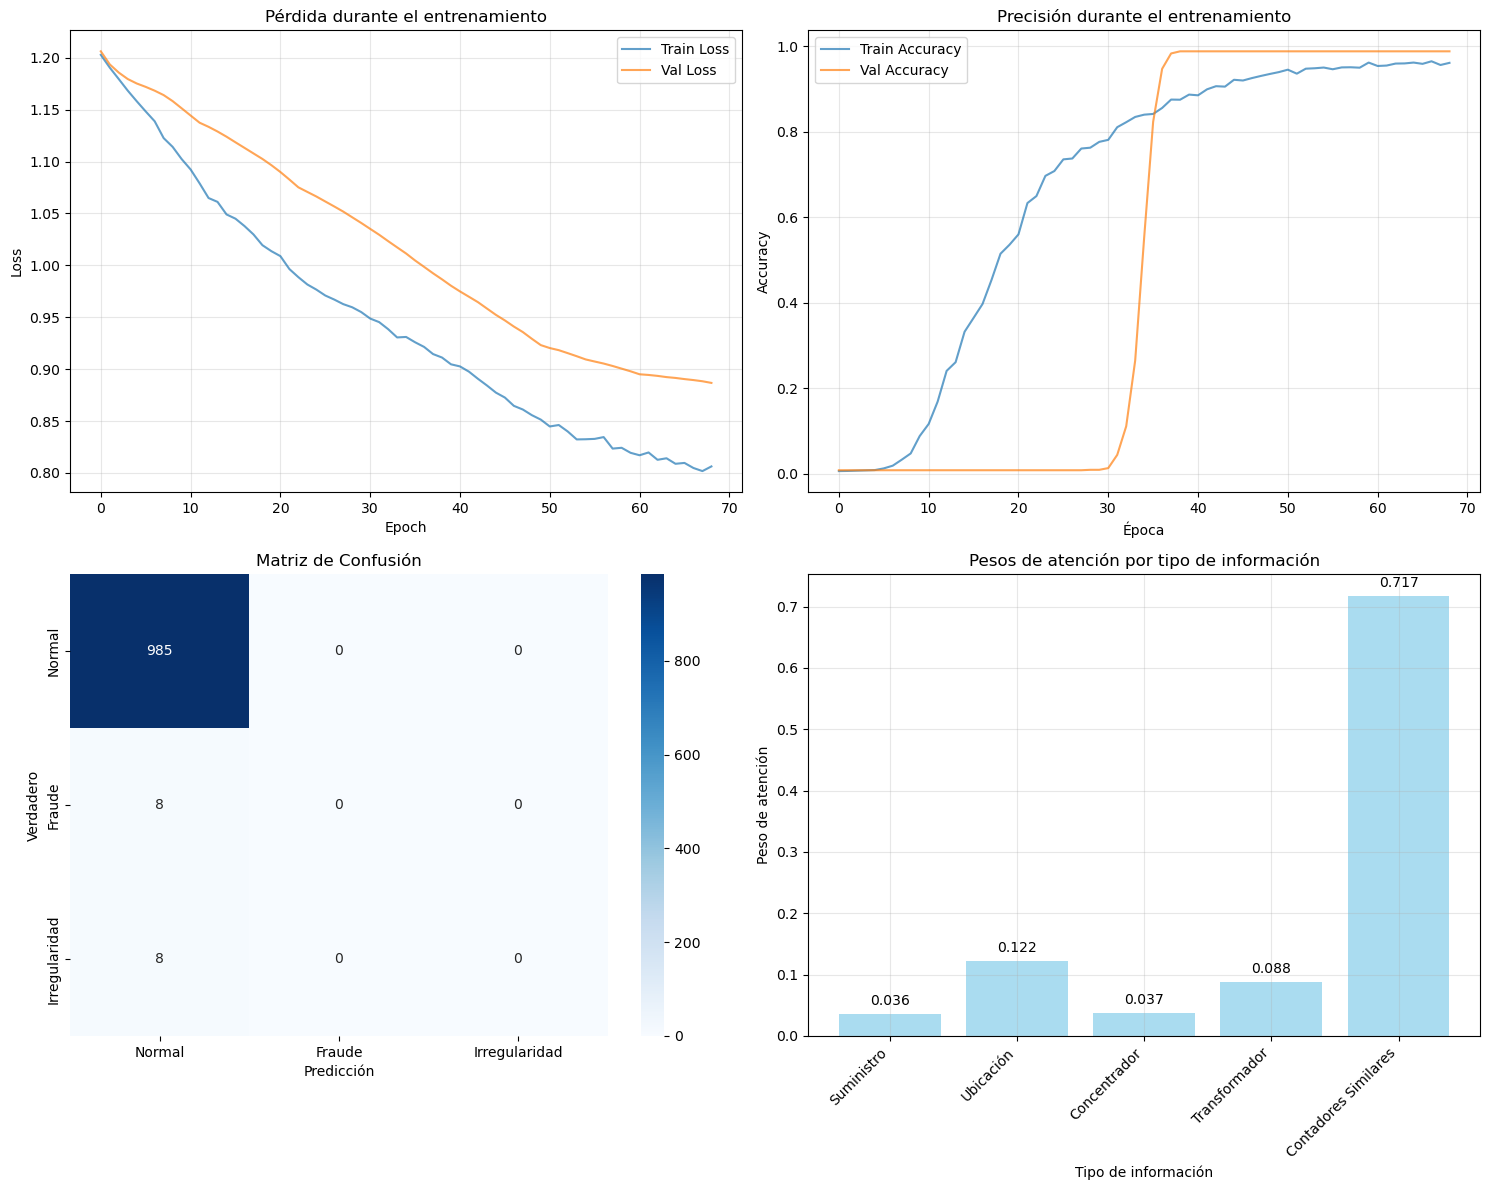

INFO:__main__:🔍 Detectando fraudes potenciales...
INFO:__main__:Fraudes potenciales detectados: 0



🎯 HETEROGENEOUS TRAINING COMPLETED
📊 ROC AUC: 0.6039
🎯 Best Val Accuracy: 0.9880
🔍 Potential fraud: 0
💾 Model saved in: models/best_hetero_fraud_model.pth


In [17]:
if __name__ == "__main__":
    # Configure seeds
    torch.manual_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    
    print("🚀 STARTING GNN HETEROGENEOUS MODEL WITH NEO4J DATA")
    print("=" * 60)
    
    # Create the directory "models" in case it douesn't exist
    os.makedirs('models', exist_ok=True)
    
    # Execute the principal pipeline
    results = main_heterogeneous_neo4j()
    
    if results is not None:
        print("\n" + "=" * 60)
        print("🎯 HETEROGENEOUS TRAINING COMPLETED")
        print("=" * 60)
        print(f"📊 ROC AUC: {results['test_results']['roc_auc']:.4f}")
        print(f"🎯 Best Val Accuracy: {results['history']['best_val_acc']:.4f}")
        print(f"🔍 Potential fraud: {len(results['potential_frauds'])}")
        print(f"💾 Model saved in: models/best_hetero_fraud_model.pth")
        
        # # Additional analysis
        # analyzer = HeterogeneousModelAnalyzer(
        #     results['model'], 
        #     results['hetero_data'], 
        # )
        
        # # Analyze nodes importance
        # important_nodes = analyzer.analyze_node_importance(top_k=5)
        # print(f"\n🔝 Top 5 nodos más importantes:")
        # for i, node in enumerate(important_nodes, 1):
        #     print(f"  {i}. NIS: {node['nis_rad']} | {node['marca']} {node['modelo']} | Score: {node['importance_score']:.3f}")
        
        # # Generate risk report
        # risk_report = analyzer.generate_fraud_risk_report(threshold=0.7)
        # print(f"\n⚠️  Risk report:")
        # print(f"  Total CONTADORES: {risk_report['total_contadores']:,}")
        # print(f"  High risk: {risk_report['high_risk_count']} ({risk_report['high_risk_percentage']:.1f}%)")
        # print(f"  Mean score value: {risk_report['average_fraud_score']:.3f}")
        
        # if risk_report['high_risk_nodes']:
        #     print(f"\n🚨 Top 3 contadores de mayor riesgo:")
        #     for i, node in enumerate(risk_report['high_risk_nodes'][:3], 1):
        #         print(f"  {i}. NIS: {node['nis_rad']} | {node['marca']} {node['modelo']} | Riesgo: {node['fraud_probability']:.3f}")
        
        # print("\n✅ ANALYSIS COMPLETED")
    else:
        print("\n❌ ERROR: The analysis couldn't be completed")
        print("Verify the Neo4j connection and that data exist in the database.")